<h1><center> 
    Neural network design and application
</center></h1>

<h2><center>CPT_S 434/534, 2022 Spring</center></h2>

<h2><center>HW 1: ML basics -- Part 2 (60 pts)</center></h2>

### Name: *[INPUT YOUR NAME HERE]*

## This assignment includes:

## Coding in Python (pytorch): train softmax classifiers on MNIST (60 points)

Step 0: Install and configure: python ([Anaconda platform](https://docs.anaconda.com/anaconda/install/) recommended), [Jupyter Notebook](https://jupyter.org/install) and [pytorch](https://pytorch.org/get-started/) 

**Remark 1.** [Colab](https://colab.research.google.com) is a cloud platform that enables your Jupyter Notebooks (including this .ipynb assignment) to run with different runtime types (hardware acceleration is possible using GPU or TPU). You may also choose Colab to finish assignments (future assignments may require extensive computation that may be time-consuming on your laptop). 

**Remark 2.** If you use Colab, make sure the working path/directory is the current one. See [this page](https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter).

**Remark 3.** If you use Colab, it is still required to convert your .ipynb to .html and submit **BOTH** files to Canvas. See [this page](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab) on how to convert to .html

Step 1: Read provided code (with pytorch) to understand the logic of design and target, so that you know how to implement in the following step and incorporate your code into the provided code

Step 2: Complete the code of mini-batch SGD (**22 pts**) for linear softmax classifier on [MNIST](http://yann.lecun.com/exdb/mnist/) and other six new settings (3 pts each, **18 pts** in total). This implementation requires a controllable L2 regularization term, i.e., $\frac{\lambda}{2} \| {\bf{w}} \|^2_2$ (otherwise you may not see any difference in some of the following six settings). See the definition of loss in function eval().

Step 3: Record and plot results to show the loss and accuracy convergence (against #epoch)

Step 4: Answer the five questions at the end of this file (4 pts each, **20 pts** in total)

## Submission:

* Convert the .ipynb file to .html file (**save the execution outputs** to show your progress: otherwise grading may be affected)
    
* Upload **both** your .ipynb and .html files to Canvas.

* Deadline: Jan 30, 11:59 PM, Pacific time.

* Plots should be clear and easy to read.

## 1. (Read and run) Load/Download MNIST dataset using pytorch

In [1]:
import matplotlib.pyplot as plt
import numpy
from torchvision import datasets, transforms

train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

x_train = train_set.data.numpy()
x_train = x_train.reshape(len(x_train),-1)
x_test = test_set.data.numpy()
x_test = x_test.reshape(len(x_test),-1)

y_train = train_set.targets.numpy()
y_test = test_set.targets.numpy()

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


## 2. (Read and run) Scale features

In [2]:
# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

## 3. (Read and run) Visualize a random image

Its label is
8


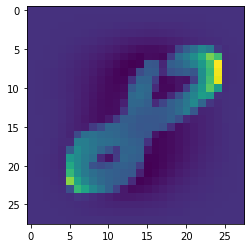

In [3]:
d = x_train.shape[0]
random_index = numpy.random.randint(d, size=1)[0]
plt.imshow(x_train[random_index].reshape(28,28))
print('Its label is')
print(y_train[random_index])

## 4. (Read and run) Define softmax function and cross entropy loss

In [5]:
def softmax(z):
    """implement the softmax functions
    input: numpy ndarray
    output: numpy ndarray
    """
    exp_list = numpy.exp(z)
    result = 1/sum(exp_list) * exp_list
    result = result.reshape((len(z),1))
    assert (result.shape == (len(z),1))
    return result

def neg_log_loss(pred, label):
    """implement the negative log loss"""
    loss = -numpy.log(pred[int(label)])
    return loss



## 2.4 (Read and run) Functions for implementing linear softmax classifier

In [6]:
import os
import sys
import json

root = os.path.abspath('.')
root += '/configs/'

def loadConfig(name):
    """ Read a configuration file as a dictionary"""
    full_path = root + name
    json_file = open(full_path, 'r')
    cfg = json.load(json_file)
    json_file.close()
    return cfg  

def initialize(num_inputs,num_classes):
    """initialize the parameters"""
    # num_inputs = 28*28 = 784
    # num_classes = 10
    w = numpy.zeros((num_classes, num_inputs)) # (10*784)
    b = numpy.zeros((num_classes, 1)) # (10*1) 
    
    param = {
        'w' : w, # (10*784)
        'b' : b  # (10*1)
    }
    return param

def eval(param, hyp, x_data, y_data):
    """ implement the evaluation function
    input: param -- parameters dictionary (w, b)
           hyp -- hyper-parameter: we use hyp['lambda'] to compute regularization
           x_data -- x_train or x_test (size, 784)
           y_data -- y_train or y_test (size,)
    output: loss and accuracy
    """
    
    reg_lambda = hyp['lambda']
    
    # w: (10*784), x: (10000*784), y:(10000,)
    loss_list = []
    w = param['w'].transpose()
    b = param['b']
    dist = numpy.array([numpy.squeeze(softmax(numpy.matmul(x_data[i], w))) for i in range(len(y_data))])

    result = numpy.argmax(dist,axis=1)
    accuracy = sum(result == y_data)/float(len(y_data))

    loss_list = [neg_log_loss(dist[i],y_data[i]) for i in range(len(y_data))]
    loss = sum(loss_list) / len(loss_list) + reg_lambda/2 * numpy.sum(w * w) + reg_lambda/2 * numpy.sum(b * b)
    return loss, accuracy

def train(param, hyp, x_train, y_train, x_test, y_test,cfg_idx):
    """ implement the train function
    input: param -- parameters dictionary (w, b)
           hyp -- hyperparameters dictionary
           x_train -- (60000, 784)
           y_train -- (60000,)
           x_test -- x_test (10000, 784)
           y_test -- y_test (10000,)
    output: train_loss_list, train_acc_list, test_loss_list, test_acc_list
           Four lists contain the epoch-wise loss function on training data, accuracy on training data, loss function on testing data, accuracy on testing data, respectively
    """
    num_epoches = hyp['num_epoches']
    batch_size = hyp['batch_size']
    learning_rate = hyp['learning_rate']
    mu = hyp['mu']
    reg_lambda = hyp['lambda']
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [],[],[],[]
    if bool(hyp['momentum']) == True:
        w_velocity = numpy.zeros(param['w'].shape)
        b_velocity = numpy.zeros(param['b'].shape) 
 
    for epoch in range(num_epoches):
        
        # select the random sequence of training set
        rand_indices = numpy.random.choice(x_train.shape[0],x_train.shape[0],replace=False)
        num_batch = int(x_train.shape[0]/batch_size)
        
        if bool(hyp['learning_decay']) == True:
            try:
                if test_acc_list[-1] - test_acc_list[-2] < 0.001:
                    learning_rate *= hyp['decay_factor']
            except:
                pass
            
            message = 'learning rate: %.8f' % learning_rate
            print(message)
            logging.info(message)

        # for each batch of train data
        for batch in range(num_batch):
            index = rand_indices[batch_size*batch:batch_size*(batch+1)]
            x_batch = x_train[index]
            y_batch = y_train[index]

            # calculate the stochastic gradient w.r.t w and b
            dw, db, batch_loss = mini_batch_gradient(param, x_batch, y_batch, reg_lambda)

            param['w'] -= learning_rate * dw
            param['b'] -= learning_rate * db
            
            if (batch+1) % 100 == 0:
                message = 'Epoch [%d/%d], Batch [%d/%d], Loss %.4f' % (epoch+1, num_epoches, batch+1, num_batch, batch_loss)
                print(message)

        train_loss, train_acc = eval(param,hyp,x_train,y_train)
        test_loss, test_acc = eval(param,hyp,x_test,y_test)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        message = 'Epoch %d/%d, Train Loss %.4f, Train Acc %.4f, Test Loss %.4f, Test Acc %.4f' % (epoch+1, num_epoches, train_loss, train_acc, test_loss, test_acc)
        print(message)
        logging.info(message)
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list


def plot(train_loss_list, train_acc_list, test_loss_list, test_acc_list, cfg_idx):
    """store the plots"""
    # epoch_list = list(range(len(loss_list)))
    plt.plot(train_loss_list, '-b', label='train loss')
    plt.plot(test_loss_list, '-r', label='test loss')
    plt.legend()
    plt.ylabel('Loss Function')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Loss Function ~ Epoch')
    plt.savefig('assets/loss_{}.png'.format(cfg_idx))
    plt.show()
    
    plt.plot(train_acc_list, '-b', label='train acc')
    plt.plot(test_acc_list, '-r', label='test acc')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Accuracy ~ Epoch')
    plt.savefig('assets/accr_{}.png'.format(cfg_idx))
    plt.show()
    

def main(cfg_idx): 
#     cfg_idx = args.config
    cfg_name = 'config_{}.json'.format(cfg_idx)
    hyperpara = loadConfig(cfg_name)

    # setting the random seed
    numpy.random.seed(1024)

    # initialize the parameters
    num_inputs = x_train.shape[1]
    num_classes = len(set(y_train))
    param = initialize(num_inputs,num_classes)

    # train the model
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = train(param,hyperpara,x_train,y_train,x_test,y_test, cfg_idx)

    # plot the loss and accuracy
    plot(train_loss_list, train_acc_list, test_loss_list, test_acc_list, cfg_idx)

## 2.5. (To finish, 22 pts) Implementation of mini-batch SGD

In [15]:
def mini_batch_gradient(param, x_batch, y_batch, reg_lambda):
    """implement the function to compute the mini batch gradient
    input: param -- parameters dictionary (w, b)
           x_batch -- a batch of x (size, 784)
           y_batch -- a batch of y (size,)
           reg_lambdba -- regularization parameter
    output: 
           dw -- derivative for weight w
           db -- derivative for bias b
           batch_loss -- average loss on the mini-batch samples
    """
    w = param['w']
    b = param['b']
    dw = numpy.zeros(w.shape)
    db = numpy.zeros(b.shape)
    # Your code goes here
    for i in range(x_batch.shape[0]):
        x_i = x_batch[i]
        y_i = y_batch[i]
        sumExp = 0
        allExp = numpy.zeros(10)
        for k in range(len(w)):
            allExp[k] = numpy.exp(numpy.matmul(w[k], x_i))
            sumExp += allExp[k]
        for k in range(len(w)):
            if y_i == k:
                dw[k] += (allExp[k] / sumExp - 1) * x_i
            else:
                dw[k] += (allExp[k] / sumExp) * x_i
                
    dw = dw / x_batch.shape[0] + (reg_lambda * w)
    return dw, db, 0
    # return dw, db, batch_loss

## 2.6. (Read and run) Train your model using the provided configuration "setting 1" (in *configs/config_setting_1.json*) untill convergence 

In [16]:
if os.path.isdir('logs') == False:
    os.mkdir('logs')
    
if os.path.isdir('assets') == False:
    os.mkdir('assets')
    
    
    
if __name__ == "__main__":

    cfg_idx = 'setting_1'

# configuration in setting 1:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 6000,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

Epoch 1/50, Train Loss 0.6474, Train Acc 0.8485, Test Loss 0.6310, Test Acc 0.8568
Epoch 2/50, Train Loss 0.5096, Train Acc 0.8733, Test Loss 0.4951, Test Acc 0.8789
Epoch 3/50, Train Loss 0.4527, Train Acc 0.8830, Test Loss 0.4399, Test Acc 0.8868
Epoch 4/50, Train Loss 0.4203, Train Acc 0.8897, Test Loss 0.4088, Test Acc 0.8923


KeyboardInterrupt: 

## 2.7. (To finish, 3 pts) Create a new configuration file for setting 2 (see below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.0000
Epoch 1/50, Train Loss 0.3483, Train Acc 0.9040, Test Loss 0.3427, Test Acc 0.9050
Epoch [2/50], Batch [100/100], Loss 0.0000
Epoch 2/50, Train Loss 0.3134, Train Acc 0.9120, Test Loss 0.3135, Test Acc 0.9123
Epoch [3/50], Batch [100/100], Loss 0.0000
Epoch 3/50, Train Loss 0.2981, Train Acc 0.9168, Test Loss 0.3012, Test Acc 0.9158
Epoch [4/50], Batch [100/100], Loss 0.0000
Epoch 4/50, Train Loss 0.2891, Train Acc 0.9192, Test Loss 0.2961, Test Acc 0.9165
Epoch [5/50], Batch [100/100], Loss 0.0000
Epoch 5/50, Train Loss 0.2832, Train Acc 0.9207, Test Loss 0.2931, Test Acc 0.9182
Epoch [6/50], Batch [100/100], Loss 0.0000
Epoch 6/50, Train Loss 0.2784, Train Acc 0.9218, Test Loss 0.2903, Test Acc 0.9200
Epoch [7/50], Batch [100/100], Loss 0.0000
Epoch 7/50, Train Loss 0.2747, Train Acc 0.9227, Test Loss 0.2887, Test Acc 0.9207
Epoch [8/50], Batch [100/100], Loss 0.0000
Epoch 8/50, Train Loss 0.2720, Train Acc 0.9244, Test Loss 0.2869, Test Acc

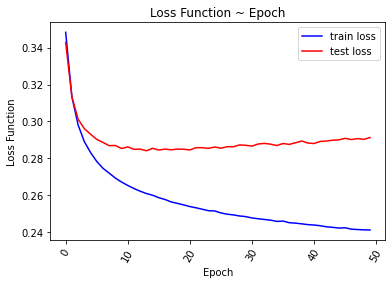

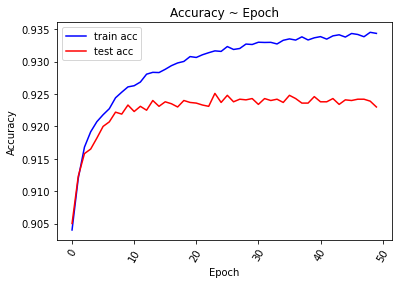

In [ ]:
if __name__ == "__main__":

    cfg_idx = 'setting_2'

# configuration in setting 2:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)    

## 2.8. (To finish, 3 pts) Create a new configuration file for setting 3 (see below) and train your model

Epoch [1/25], Batch [100/600], Loss 0.0000
Epoch [1/25], Batch [200/600], Loss 0.0000
Epoch [1/25], Batch [300/600], Loss 0.0000
Epoch [1/25], Batch [400/600], Loss 0.0000
Epoch [1/25], Batch [500/600], Loss 0.0000
Epoch [1/25], Batch [600/600], Loss 0.0000
Epoch 1/25, Train Loss 0.3023, Train Acc 0.9188, Test Loss 0.3107, Test Acc 0.9167
Epoch [2/25], Batch [100/600], Loss 0.0000
Epoch [2/25], Batch [200/600], Loss 0.0000
Epoch [2/25], Batch [300/600], Loss 0.0000
Epoch [2/25], Batch [400/600], Loss 0.0000
Epoch [2/25], Batch [500/600], Loss 0.0000
Epoch [2/25], Batch [600/600], Loss 0.0000
Epoch 2/25, Train Loss 0.2863, Train Acc 0.9222, Test Loss 0.3283, Test Acc 0.9203
Epoch [3/25], Batch [100/600], Loss 0.0000
Epoch [3/25], Batch [200/600], Loss 0.0000
Epoch [3/25], Batch [300/600], Loss 0.0000
Epoch [3/25], Batch [400/600], Loss 0.0000
Epoch [3/25], Batch [500/600], Loss 0.0000
Epoch [3/25], Batch [600/600], Loss 0.0000
Epoch 3/25, Train Loss 0.2795, Train Acc 0.9253, Test Loss 0

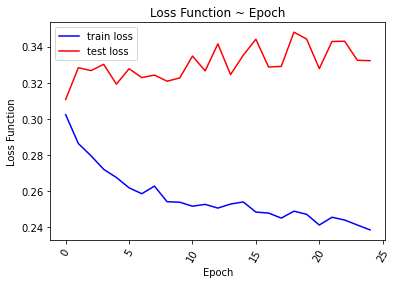

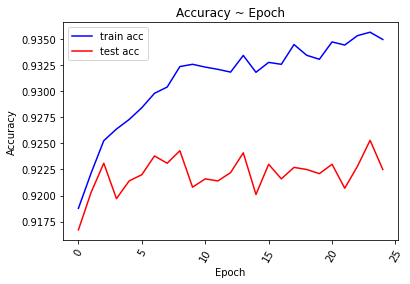

In [10]:
if __name__ == "__main__":

    cfg_idx = 'setting_3'
    
# configuration in setting 3:
#     {
#     "num_epoches" : 25,
#     "batch_size" : 100,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)
    

## 2.9. (To finish, 3 pts) Create a new configuration file for setting 4 (see below) and train your model

Epoch [1/25], Batch [100/600], Loss 0.0000
Epoch [1/25], Batch [200/600], Loss 0.0000
Epoch [1/25], Batch [300/600], Loss 0.0000
Epoch [1/25], Batch [400/600], Loss 0.0000
Epoch [1/25], Batch [500/600], Loss 0.0000
Epoch [1/25], Batch [600/600], Loss 0.0000
Epoch 1/25, Train Loss 0.3845, Train Acc 0.8962, Test Loss 0.3755, Test Acc 0.8986
Epoch [2/25], Batch [100/600], Loss 0.0000
Epoch [2/25], Batch [200/600], Loss 0.0000
Epoch [2/25], Batch [300/600], Loss 0.0000
Epoch [2/25], Batch [400/600], Loss 0.0000
Epoch [2/25], Batch [500/600], Loss 0.0000
Epoch [2/25], Batch [600/600], Loss 0.0000
Epoch 2/25, Train Loss 0.3376, Train Acc 0.9061, Test Loss 0.3332, Test Acc 0.9072
Epoch [3/25], Batch [100/600], Loss 0.0000
Epoch [3/25], Batch [200/600], Loss 0.0000
Epoch [3/25], Batch [300/600], Loss 0.0000
Epoch [3/25], Batch [400/600], Loss 0.0000
Epoch [3/25], Batch [500/600], Loss 0.0000
Epoch [3/25], Batch [600/600], Loss 0.0000
Epoch 3/25, Train Loss 0.3174, Train Acc 0.9113, Test Loss 0

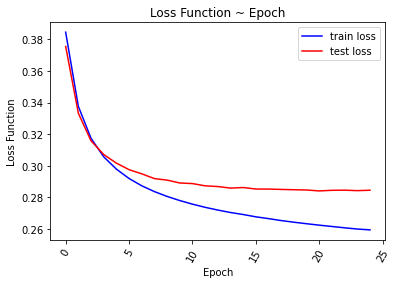

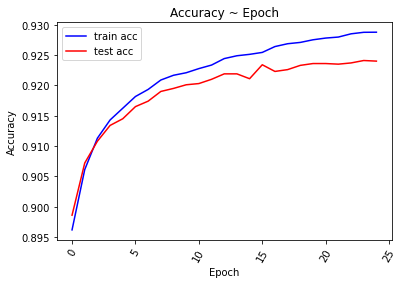

In [11]:
if __name__ == "__main__":

    cfg_idx = 'setting_4'
    
# configuration in setting 4:
# {
#     "num_epoches" : 25,
#     "batch_size" : 100,
#     "learning_rate" : 0.01,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.00,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 2.10. (To finish, 3 pts) Create a new configuration file for setting 5 (see below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.0000
Epoch 1/50, Train Loss 0.3512, Train Acc 0.9040, Test Loss 0.3457, Test Acc 0.9050
Epoch [2/50], Batch [100/100], Loss 0.0000
Epoch 2/50, Train Loss 0.3176, Train Acc 0.9120, Test Loss 0.3177, Test Acc 0.9123
Epoch [3/50], Batch [100/100], Loss 0.0000
Epoch 3/50, Train Loss 0.3033, Train Acc 0.9168, Test Loss 0.3064, Test Acc 0.9158
Epoch [4/50], Batch [100/100], Loss 0.0000
Epoch 4/50, Train Loss 0.2951, Train Acc 0.9192, Test Loss 0.3021, Test Acc 0.9165
Epoch [5/50], Batch [100/100], Loss 0.0000
Epoch 5/50, Train Loss 0.2898, Train Acc 0.9207, Test Loss 0.2997, Test Acc 0.9182
Epoch [6/50], Batch [100/100], Loss 0.0000
Epoch 6/50, Train Loss 0.2856, Train Acc 0.9218, Test Loss 0.2975, Test Acc 0.9200
Epoch [7/50], Batch [100/100], Loss 0.0000
Epoch 7/50, Train Loss 0.2824, Train Acc 0.9227, Test Loss 0.2964, Test Acc 0.9207
Epoch [8/50], Batch [100/100], Loss 0.0000
Epoch 8/50, Train Loss 0.2802, Train Acc 0.9244, Test Loss 0.2951, Test Acc

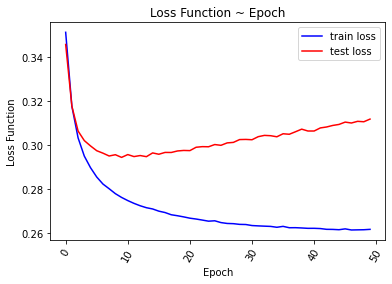

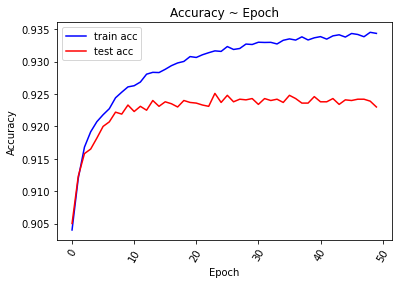

In [12]:
if __name__ == "__main__":

    cfg_idx = 'setting_5'
    
# configuration in setting 5:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.001,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 2.11. (To finish, 3 pts) Create a new configuration file for setting 6 (see below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.0000
Epoch 1/50, Train Loss 0.3777, Train Acc 0.9040, Test Loss 0.3722, Test Acc 0.9050
Epoch [2/50], Batch [100/100], Loss 0.0000
Epoch 2/50, Train Loss 0.3557, Train Acc 0.9120, Test Loss 0.3558, Test Acc 0.9123
Epoch [3/50], Batch [100/100], Loss 0.0000
Epoch 3/50, Train Loss 0.3499, Train Acc 0.9168, Test Loss 0.3530, Test Acc 0.9158
Epoch [4/50], Batch [100/100], Loss 0.0000
Epoch 4/50, Train Loss 0.3485, Train Acc 0.9192, Test Loss 0.3555, Test Acc 0.9165
Epoch [5/50], Batch [100/100], Loss 0.0000
Epoch 5/50, Train Loss 0.3491, Train Acc 0.9207, Test Loss 0.3590, Test Acc 0.9182
Epoch [6/50], Batch [100/100], Loss 0.0000
Epoch 6/50, Train Loss 0.3502, Train Acc 0.9218, Test Loss 0.3622, Test Acc 0.9200
Epoch [7/50], Batch [100/100], Loss 0.0000
Epoch 7/50, Train Loss 0.3518, Train Acc 0.9227, Test Loss 0.3658, Test Acc 0.9207
Epoch [8/50], Batch [100/100], Loss 0.0000
Epoch 8/50, Train Loss 0.3542, Train Acc 0.9244, Test Loss 0.3690, Test Acc

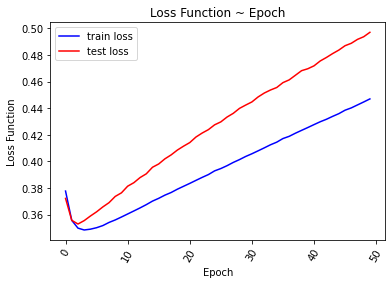

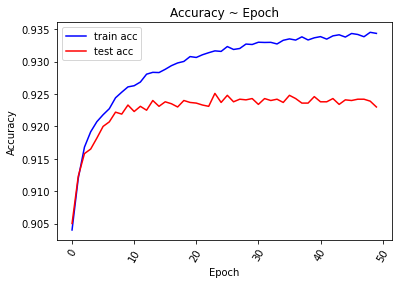

In [13]:
if __name__ == "__main__":

    cfg_idx = 'setting_6'
    
# configuration in setting 6:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.01,
#     "mu" : 0.9
# }
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 2.12. (To finish, 3 pts) Create a new configuration file for setting 7 (see below) and train your model

Epoch [1/50], Batch [100/100], Loss 0.0000
Epoch 1/50, Train Loss 0.6432, Train Acc 0.9040, Test Loss 0.6377, Test Acc 0.9050
Epoch [2/50], Batch [100/100], Loss 0.0000
Epoch 2/50, Train Loss 0.7368, Train Acc 0.9120, Test Loss 0.7369, Test Acc 0.9123
Epoch [3/50], Batch [100/100], Loss 0.0000
Epoch 3/50, Train Loss 0.8158, Train Acc 0.9168, Test Loss 0.8189, Test Acc 0.9158
Epoch [4/50], Batch [100/100], Loss 0.0000
Epoch 4/50, Train Loss 0.8831, Train Acc 0.9192, Test Loss 0.8901, Test Acc 0.9165
Epoch [5/50], Batch [100/100], Loss 0.0000
Epoch 5/50, Train Loss 0.9424, Train Acc 0.9207, Test Loss 0.9522, Test Acc 0.9182
Epoch [6/50], Batch [100/100], Loss 0.0000
Epoch 6/50, Train Loss 0.9968, Train Acc 0.9218, Test Loss 1.0088, Test Acc 0.9200
Epoch [7/50], Batch [100/100], Loss 0.0000
Epoch 7/50, Train Loss 1.0462, Train Acc 0.9227, Test Loss 1.0602, Test Acc 0.9207
Epoch [8/50], Batch [100/100], Loss 0.0000
Epoch 8/50, Train Loss 1.0935, Train Acc 0.9244, Test Loss 1.1084, Test Acc

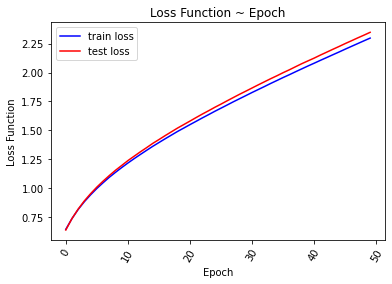

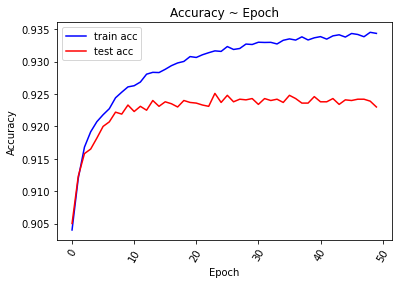

In [14]:
if __name__ == "__main__":

    cfg_idx = 'setting_7'
    
# configuration in setting 7:
#     {
#     "num_epoches" : 50,
#     "batch_size" : 600,
#     "learning_rate" : 0.1,
#     "learning_decay" : 0,
#     "decay_factor" : 0.75,
#     "momentum" : 0,
#     "lambda" : 0.1,
#     "mu" : 0.9
# }
    
    
    import logging
    logging.basicConfig(filename="./logs/{}.log".format(cfg_idx), filemode="w", format="%(message)s", level=logging.DEBUG)
    
    main(cfg_idx)

## 2.13. (To finish, 4 pts each question, 20 pts in total) Answer the following five questions

### Q1 (4 pts): Comparing results of setting 1 and setting 2, what conclusion can we draw? What is the key reason of the significant difference between the two results?

**Answer**:






### Q2 (4 pts): Comparing results of setting 2 and setting 3, what conclusion can we draw? What is the key reason of the significant difference between the two results? 

**Answer**:






### Q3 (4 pts): Comparing results of setting 3 and setting 4, what conclusion can we draw? What is the key reason of the significant difference between the two results? 

**Answer**:






### Q4 (4 pts): Comparing results of setting 2, 5 and 6, what conclusion can we draw? What is the key reason of the significant difference between the two results? 

**Answer**:






### Q5 (4 pts): What may happen to setting 7, compared to settings 2, 5 and 6?

**Answer**:




